In [2]:
### AAE 722 Lab 11 - Charles Voigt
# Housekeeping - importing relevant libraries
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

from lifelines import \
(KaplanMeierFitter,
 CoxPHFitter,)

from lifelines.statistics import \
(logrank_test, 
 multivariate_logrank_test)
from ISLP.survival import sim_time

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Question 1 Part a - Data Generation - generated using Lab11DataGeneration.ipynb
# Set random seed for reproducibility (following ISLP lab convention)
rng = np.random.default_rng(2025)

# Simulate 500 employees hired over a 5-year period
n_employees = 500

# Department assignment (5 departments with realistic proportions)
# Engineering is largest, HR smallest (typical for tech companies)
departments = rng.choice(
    ['Engineering', 'Sales', 'Marketing', 'HR', 'Operations'], 
    size=n_employees, 
    p=[0.40, 0.25, 0.18, 0.08, 0.09]
)

# Years of prior work experience at hire (0-20 years)
# Use exponential distribution to create right-skewed realistic experience levels
experience = rng.exponential(scale=4.5, size=n_employees)
experience = np.clip(experience, 0, 20)

# Performance rating (1.0-5.0 scale, where higher is better)
# Centered at 3.5 with standard deviation of 0.7 to create realistic distribution
performance = rng.normal(loc=3.5, scale=0.7, size=n_employees)
performance = np.clip(performance, 1.0, 5.0)

# Starting salary in thousands (correlated with experience and department)
# Different departments have different base salary structures
dept_salary_base = {
    'Engineering': 95,  # Highest base (competitive tech market)
    'Sales': 72,        # Lower base but typically has commission
    'Marketing': 78,    # Moderate base
    'HR': 68,           # Lower base
    'Operations': 85    # Good base (technical operations)
}
base_salary = np.array([dept_salary_base[d] for d in departments])
# Add experience premium (~$2.5k per year) plus random variation
salary = base_salary + 2.5 * experience + rng.normal(0, 8, n_employees)
salary = np.clip(salary, 45, 160)

# Remote work assignment (binary: 1 = remote, 0 = on-site)
# Engineering has highest remote proportion, Operations lowest
remote_prob = np.where(
    departments == 'Engineering', 0.60,  # Engineering: 60% remote
    np.where(departments == 'Operations', 0.15,  # Operations: 15% remote
             np.where(departments == 'Sales', 0.40,  # Sales: 40% remote
                     np.where(departments == 'Marketing', 0.45, 0.35)))  # Marketing: 45%, HR: 35%
)
remote_work = rng.binomial(1, remote_prob)

print("Covariates generated successfully!")
print(f"Sample size: {n_employees} employees")
print(f"Remote work proportion: {remote_work.mean():.1%}")

Covariates generated successfully!
Sample size: 500 employees
Remote work proportion: 45.2%


In [4]:
# Simulate employment duration (time until departure) using Cox model structure
# Different departments have different baseline retention patterns
dept_hazard_effects = {
    'Engineering': -0.40,   # Best retention (negative = lower hazard)
    'Sales': 0.45,          # Worst retention (positive = higher hazard)
    'Marketing': 0.18,      # Moderate-poor retention
    'HR': 0.08,             # Moderate retention
    'Operations': -0.25     # Good retention
}
dept_effect = np.array([dept_hazard_effects[d] for d in departments])

# Calculate hazard rate (risk of leaving) based on multiple factors
# Cox model structure: λ(t) = λ₀(t) × exp(β₁X₁ + β₂X₂ + ...)
# Protective factors (negative coefficients): experience, performance, salary, remote work
log_hazard = (
    dept_effect +                          # Department effect
    -0.10 * experience +                   # Each year experience reduces hazard by 9.5% (exp(-0.10)≈0.905)
    -0.40 * (performance - 3.5) +          # Higher performance is strongly protective
    -0.018 * (salary - 85) +               # Higher salary reduces departure risk
    -0.35 * remote_work +                  # Remote work reduces hazard by 30% (exp(-0.35)≈0.70)
    -1.5                                   # Baseline log-hazard
)
lambda_hazard = np.exp(log_hazard)  # Convert to hazard rate

# Generate time to departure from exponential distribution (months)
# Exponential distribution is memoryless and commonly used in survival simulation
time_to_departure = rng.exponential(scale=1/lambda_hazard, size=n_employees)

# Add administrative censoring (employees still at company at study end)
# Study duration varies by employee (12-60 months observation window)
# This creates realistic Type I censoring
study_duration = rng.uniform(low=12, high=60, size=n_employees)

# Observed time is minimum of departure time and censoring time
observed_time = np.minimum(time_to_departure, study_duration)
# Event indicator: 1 = departed (event observed), 0 = still employed (censored)
event_indicator = (time_to_departure <= study_duration).astype(int)

print(f"Survival times generated!")
print(f"Events (departures): {event_indicator.sum()}")
print(f"Censored (still employed): {(1 - event_indicator).sum()}")
print(f"Censoring rate: {(1 - event_indicator).mean():.1%}")

Survival times generated!
Events (departures): 433
Censored (still employed): 67
Censoring rate: 13.4%


In [5]:
# Create final DataFrame with all variables
retention_data = pd.DataFrame({
    'time': observed_time,                    # Employment duration in months
    'event': event_indicator,                 # 1 = left company, 0 = still employed
    'department': pd.Categorical(departments), # Department (categorical)
    'experience': experience,                 # Years of prior experience (continuous)
    'performance': performance,               # Performance rating 1-5 (continuous)
    'salary': salary,                         # Starting salary in thousands (continuous)
    'remote_work': remote_work                # 1 = remote, 0 = on-site (binary)
})

print("=" * 70)
print("EMPLOYEE RETENTION DATASET CREATED")
print("=" * 70)
print(f"Dataset dimensions: {retention_data.shape[0]} employees × {retention_data.shape[1]} variables")
print(f"\nFirst 10 observations:")
print(retention_data.head(10))

EMPLOYEE RETENTION DATASET CREATED
Dataset dimensions: 500 employees × 7 variables

First 10 observations:
        time  event   department  experience  performance      salary  \
0   4.137837      1   Operations    0.841920     2.655509   92.316205   
1   3.282764      1  Engineering    0.946957     3.380019   92.603354   
2  18.432079      1    Marketing    9.409169     2.735693   98.144888   
3   4.663205      1           HR    5.583752     2.030922   76.167897   
4   2.323511      1   Operations    0.686558     3.539874   79.926189   
5  14.018088      1  Engineering    2.070775     3.140689  104.693788   
6  39.645606      0  Engineering   15.157682     4.367160  138.590670   
7   4.476022      1   Operations    3.327090     3.320088   81.560671   
8   4.057824      1    Marketing    2.883564     3.737368   96.047723   
9  16.240357      0  Engineering   15.727998     3.492641  123.907938   

   remote_work  
0            0  
1            1  
2            1  
3            1  
4   

<Axes: xlabel='timeline'>

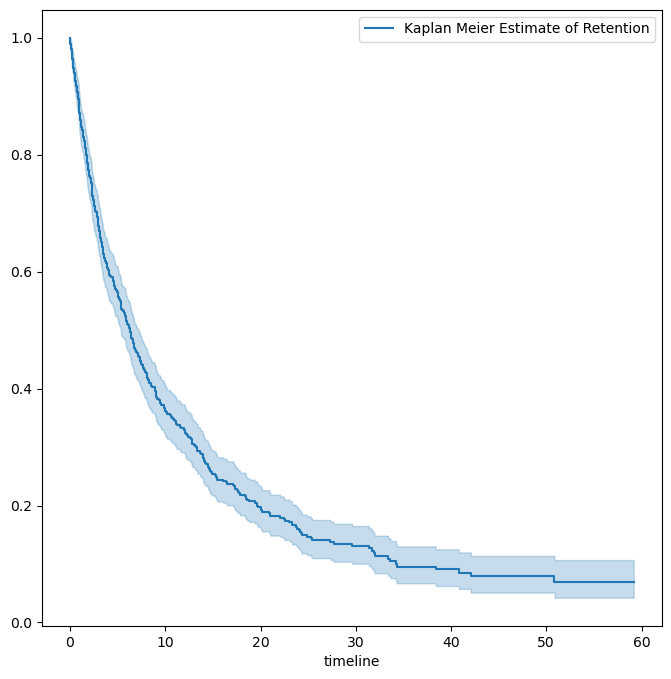

In [6]:
#Question 1 parts b/c
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_retention = km.fit(retention_data['time'], retention_data['event'])
km_retention.plot(label='Kaplan Meier Estimate of Retention', ax=ax)

In [9]:
#Question 1 Part d
median_retention_time = km_retention.median_survival_time_
quartile_percentile_time = km_retention.percentile(0.25)
three_quartile_percentile_time = km_retention.percentile(0.75)
retention_at_12_months = km_retention.survival_function_at_times(12).values[0]
retention_at_24_months = km_retention.survival_function_at_times(24).values[0]
retention_at_48_months = km_retention.survival_function_at_times(48).values[0]

km1df = pd.DataFrame({
    'Metric': ['Median Retention Time (months)', 
               '25th Percentile Retention Time (months)', 
               '75th Percentile Retention Time (months)',
               'Retention Probability at 12 Months',
               'Retention Probability at 24 Months',
               'Retention Probability at 48 Months'],
    'Value': [median_retention_time, 
              quartile_percentile_time, 
              three_quartile_percentile_time,
              retention_at_12_months,
              retention_at_24_months,
              retention_at_48_months]
})
print("\nKaplan-Meier Retention Metrics:")
print(km1df)


Kaplan-Meier Retention Metrics:
                                    Metric      Value
0           Median Retention Time (months)   6.289403
1  25th Percentile Retention Time (months)  15.339461
2  75th Percentile Retention Time (months)   2.256886
3       Retention Probability at 12 Months   0.332000
4       Retention Probability at 24 Months   0.160601
5       Retention Probability at 48 Months   0.078708


#### Question 1 Part e Discussion

The Kaplan Meier Curve and the summary metrics from the KM estimation reveal that most employee turnover occurs within 1 year of employment, with the median tenure at about 6.3 months (only 33% of employees are retained for at least 12 months). It also shows that only 16% of employees are retained for at least 2 years, and 7% for 3 years. From an HR perspective, the KM estimate indicates that on average, filling a particular role should be expected around 6 months after an employees start date.

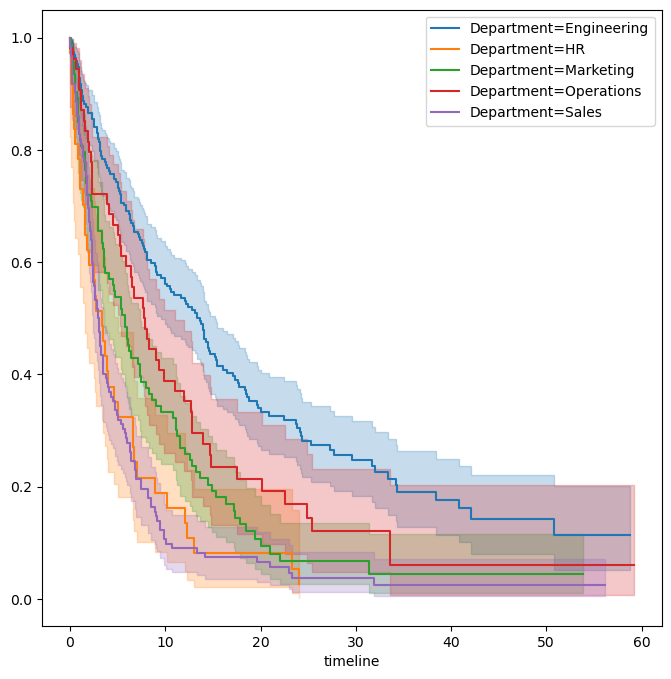

In [19]:
#Question 2 Part a/b
fig, ax = subplots(figsize=(8,8))
by_dept = {}
for department, df in retention_data.groupby('department'):
    by_dept[department] = df
    km_dept = km.fit(df['time'], df['event'])
    km_dept.plot(label ='Department=%s' % department, ax=ax)

In [23]:
median_by_dept = {}
for department, df in by_dept.items():
    km_dept = km.fit(df['time'], df['event'])
    median_by_dept[department] = km_dept.median_survival_time_

median_dept_df = pd.DataFrame({
    'Department': list(median_by_dept.keys()),
    'Median Retention Time (months)': list(median_by_dept.values())
})

print("\nMedian Retention Times by Department:")
print(median_dept_df)


Median Retention Times by Department:
    Department  Median Retention Time (months)
0  Engineering                       13.374983
1           HR                        3.354284
2    Marketing                        5.779757
3   Operations                        7.795713
4        Sales                        2.986867


#### Question 2 Part d Discussion

The highest median retention department is Engineering (13.37), and the lowest is Sales (2.99). In the graph, it looks like a drastic divergence in the survival retention of these two departments occurs around the median retention for Sales (~3 months).

#### Question 2 Part e Discussion

Sales and HR have very similar retention patterns. They are very steep, indicating that most employees are not retained for very long, with a select few having extended tenures. Marketing and Operations have less steep retention curves, with Operations having a bit better long term retention. The highest retention curve is Engineering, with a median tenure of 13.37 months, and this longer tenure can easily be seen in the graph.

This difference could be related to compensation structure within the firm, if engineers are paid higher than all other departments the employees may be easier to retain. On the flip side, if a sales employee's compensation is variable based on a commission, there may be less incentive to employed for a less successful employee. 

The differences in this retention do appear within the first 12 months, and do not widen substantially after this. This indicates that retention issues may be due to entry level compensation differences or variable compensation for lower retention departments filtering out low performers.

### Question 2 Bonus Discussion
practical interventions to boost retention in some departments may include the introduction of a 12 month bonus, an employee stock program where employees are granted some company equity based on tenure, and higher commission for more tenured employees in variable compensation positions.

In [26]:
#Question 3 part a
# Use multivariate_logrank_test for comparing multiple groups
result = multivariate_logrank_test(
    retention_data['time'],
    retention_data['department'],
    retention_data['event']
)

print(result)
print(f"\nTest statistic: {result.test_statistic:.4f}")
print(f"P-value: {result.p_value:.4f}")

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          90.11 <0.005     59.48

Test statistic: 90.1095
P-value: 0.0000


### Question 3 part b Discussion

The test statistic is 90.11, the p value is 0, and there are 4 degrees of freedom.

In [33]:
#Question 3 part c
(median_by_dept['Engineering']-median_by_dept['Sales'])/median_retention_time * 100

np.float64(165.16855240637244)

There is a 165.17% difference in median retention between engineering and sales.

### Question 3 part d Discussion

The p value of 0 indicates that the differences in retention across departments is statistically significant.

#### Question 3 Bonus Discussion

The practical differences in retention do match the statistical significance. 

The ~ 10 month difference in median retention between engineering and sales/HR represents a major challenge for this business, because talent acquisition is significant cost for any business. 

If we consider the cost of training a new employee and the learning curve (new employees will not achieve full productivity until ~6 months into a new position), then the effective cost of staffing in the Sales and HR departments could drastically exceed the staffing costs of engineering, even with lower or variable based compensations. 

A manager who is interpreting this data would conclude that closing this retention gap is critical to the efficient operations of the business.

In [ ]:
#Question 4 part a/b
cph = CoxPHFitter()
retention_df = retention_data[['department', 'experience', 'performance', 'salary', 'remote_work']]
model_df = MS(['department', 'experience', 'performance', 'salary', 'remote_work'], intercept=False).fit_transform(retention_df)

cox_fit = cph.fit(model_df.join(retention_data[['time', 'event']]), duration_col='time', event_col='event')
cox_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 500 total observations, 67 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 433
   partial log-likelihood = -2242.39
         time fit was run = 2025-11-21 17:31:52 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
department[HR]          0.76      2.14      0.24            0.29            1.23                1.33                3.43
department[Marketing]   0.54      1.72      0.17            0.21            0.87                1.24                2.38
department[Operations]  0.25      1.28      0.18           -0.11            0.60                0.90                1.83
department[Sales]       0.94      2.57      0.19            0.57            1.31                1.77                3.71
experience             -0.09      0.91      0.02           -0.13           -0.05                0.88                0.95
performance            -0.21      0.81      0.08           -0.36           -0.06                0.70                0.94
salary                 -0.02      0.98      0.01           -0.03           -0.01                0.97                0.99
remote_work            -0.52      0.60      0.10           -0.72           -0.32                0.49                0.73

                        cmp to     z      p  -log2(p)
covariate                                            
department[HR]            0.00  3.14 <0.005      9.20
department[Marketing]     0.00  3.25 <0.005      9.75
department[Operations]    0.00  1.36   0.17      2.53
department[Sales]         0.00  5.00 <0.005     20.74
experience                0.00 -4.46 <0.005     16.87
performance               0.00 -2.80   0.01      7.60
salary                    0.00 -3.46 <0.005     10.85
remote_work               0.00 -5.06 <0.005     21.19
---
Concordance = 0.71
Partial AIC = 4500.77
log-likelihood ratio test = 243.36 on 8 df
-log2(p) of ll-ratio test = 157.32

#### Question 4 part c Discussion

The concordance index is 0.71. The C index is a measure of how accurate the model is when taking into account censored data. 1 indicates a perfect fit, and 0.5 indicates a random prediction. In this case, the model will correctly predict retention time with 71% accuracy.

In [43]:
#Question 4 part d

# Get coefficients for continuous variables: experience, performance, salary
coef_exp = cox_fit.params_['experience']
coef_perf = cox_fit.params_['performance']
coef_sal = cox_fit.params_['salary']

# Get p-values to confirm significance
p_exp = cox_fit.summary.loc['experience', 'p']
p_perf = cox_fit.summary.loc['performance', 'p']
p_sal = cox_fit.summary.loc['salary', 'p']

# Compute hazard ratios for meaningful changes
# Experience: HR for 5 additional years of experience
hr_exp_5yr = np.exp(coef_exp * 5)

# Performance: HR for 1-point increase on 5-point scale
hr_perf_1pt = np.exp(coef_perf * 1)

# Salary: HR for $10k increase in salary
hr_sal_10k = np.exp(coef_sal * 10)

# Create summary DataFrame
hr_summary = pd.DataFrame({
    'Predictor': ['Experience (5 years)', 'Performance (1 point)', 'Salary ($10k)'],
    'Coefficient': [coef_exp, coef_perf, coef_sal],
    'P-value': [p_exp, p_perf, p_sal],
    'Change': ['5 years', '1 point', '$10,000'],
    'Hazard Ratio': [hr_exp_5yr, hr_perf_1pt, hr_sal_10k],
    '% Change in Hazard': [(hr_exp_5yr - 1) * 100, (hr_perf_1pt - 1) * 100, (hr_sal_10k - 1) * 100]
})
hr_summary

,Predictor,Coefficient,P-value,Change,Hazard Ratio,% Change in Hazard
0,Experience (5 years),-0.089768,0.000008,5 years,0.638367,-36.163270
1,Performance (1 point),-0.213354,0.005145,1 point,0.807870,-19.212972
2,Salary ($10k),-0.021366,0.000540,"$10,000",0.807623,-19.237715


### Question 4 part d Discussion

The hazard ratio for experience indicates that for every additional 5 years of experience is associated with a 36% less turnover rate. For performance, every 1 additional point in performance is associated with 19% less turnover. For salary, every additional $10,000 in salary is associated with 19% less turnover.

#### Question 4 Part e Discussion
 From the hazard ratios, it is clear that experience is the biggest driver of departure risk, followed by salary and then performance. The hazard ratios describe the change in retention as it applies to the changes in the continuous variables. So an observation with 5 years of experience is 36% less likely to turnover, an additional $10k in salary is 19% less likely, and additional 1 point in performance is 19% less likely to turnover. 

 For importance, salary and performance are relatively similar, but the largest driver of retention increase in experience.

 The model is 71% accurate according to the C index, which indicates to me that there is a missing signal from the data. While the model is useful for making broad generalizations about potential improvements in HR practices, I would not use it to make accurate predictions regarding a specific employee's expected tenure.